# VAE (cifar10)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Загрузка данных

In [2]:
(X_train, _), (X_test, _) = keras.datasets.cifar10.load_data()
cifar = np.concatenate([X_train, X_test], axis=0)
cifar = cifar.astype('float32') / 255.0

## Разработка модели

In [3]:
LATENT_DIM = 256

### Слой семплирования

In [4]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Энкодер

In [5]:
def encoder_block(x, num_filters):
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(num_filters, 3, activation='relu', strides=2, padding='same')(x)
    return x

In [6]:
def encoder_model(latent_dim):
    encoder_inputs = keras.Input(shape=(32, 32, 3))

    x = encoder_block(encoder_inputs, 16)
    x = encoder_block(x, 32)
    x = encoder_block(x, 64)
    x = layers.Flatten()(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

In [7]:
encoder = encoder_model(LATENT_DIM)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d_1[0][0]']               
                                                                                            

### Декодер

In [8]:
def decoder_block(x, num_filters):
    x = layers.Conv2DTranspose(num_filters, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    return x

In [9]:
def decoder_model(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((4, 4, 64))(x)
    
    x = decoder_block(x, 64)
    x = decoder_block(x, 32)
    x = decoder_block(x, 16)
    
    decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [10]:
decoder = decoder_model(LATENT_DIM)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 32)       18464     
 ranspose)                                                 

### Модель VAE

In [11]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)

            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32 * 32

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
        }

## Обучение модели

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001))
history = vae.fit(cifar,
                  epochs=25,
                  batch_size=16,
                  verbose=1,
                  callbacks=[ReduceLROnPlateau(
                      monitor='loss',
                      factor=0.2,
                      patience=3,
                      min_lr=1e-7,
                      verbose=1,
                      mode="min"
                  ),])

Epoch 1/25
3750/3750 [==============================] - 24s 6ms/step - loss: 602.8506 - reconstruction_loss: 601.2517 - kl_loss: 1.5990 - lr: 0.0010
Epoch 2/25
3750/3750 [==============================] - 22s 6ms/step - loss: 585.1850 - reconstruction_loss: 583.2979 - kl_loss: 1.8871 - lr: 0.0010
Epoch 3/25
3750/3750 [==============================] - 22s 6ms/step - loss: 581.7583 - reconstruction_loss: 579.8336 - kl_loss: 1.9247 - lr: 0.0010
Epoch 4/25
3750/3750 [==============================] - 22s 6ms/step - loss: 578.6568 - reconstruction_loss: 576.6747 - kl_loss: 1.9821 - lr: 0.0010
Epoch 5/25
3750/3750 [==============================] - 22s 6ms/step - loss: 576.4160 - reconstruction_loss: 574.3907 - kl_loss: 2.0253 - lr: 0.0010
Epoch 6/25
3750/3750 [==============================] - 22s 6ms/step - loss: 574.9548 - reconstruction_loss: 572.8992 - kl_loss: 2.0556 - lr: 0.0010
Epoch 7/25
3750/3750 [==============================] - 22s 6ms/step - loss: 574.0127 - reconstruction_los

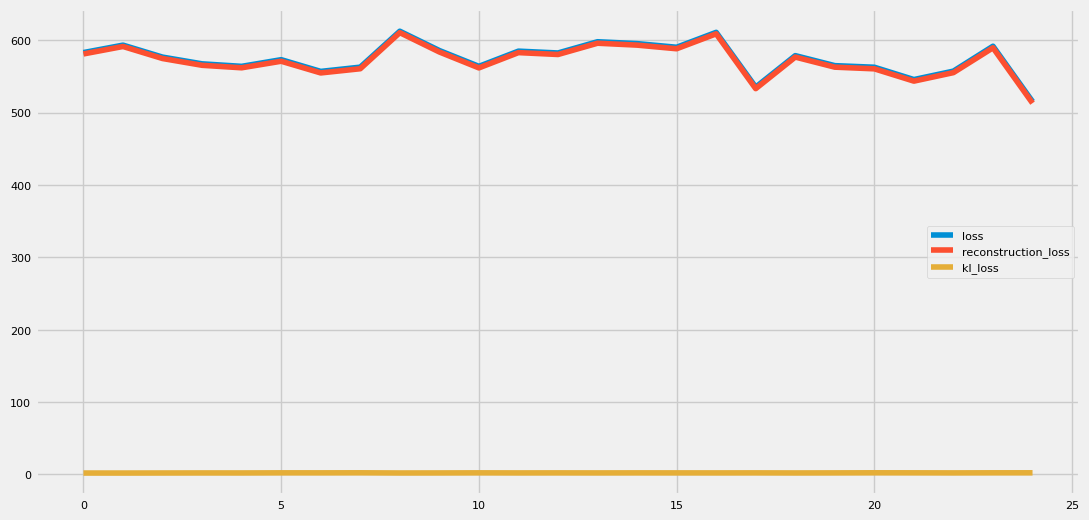

In [13]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    for key in ['loss', 'reconstruction_loss', 'kl_loss']:
        plt.plot(history[key], label=key)
        plt.grid(True)
        plt.legend()

    plt.show()

plot_history(history.history)

1/1 [==============================] - 0s 95ms/step


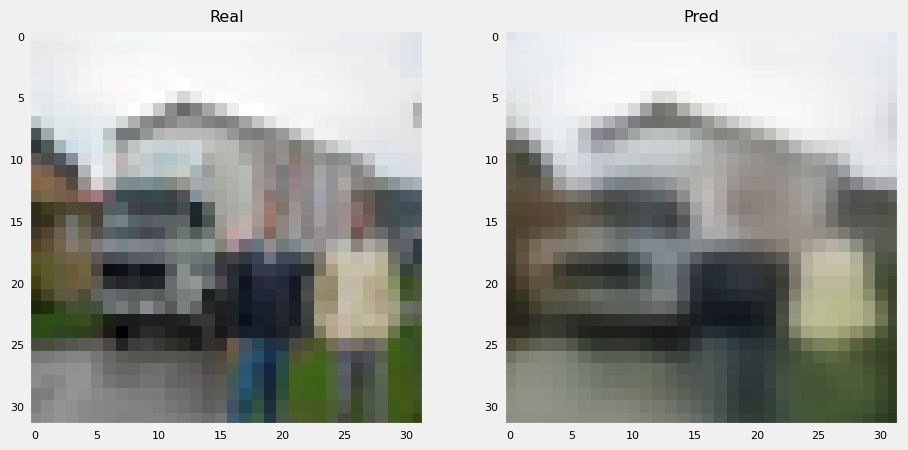

In [14]:
idx = 16
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(cifar[idx])
plt.title('Real')
plt.grid(False)

plt.subplot(1, 2, 2)
_, _, z = encoder.predict(np.array([cifar[idx],]))
plt.imshow(decoder.predict(z)[0])
plt.title('Pred')
plt.grid(False)

plt.show()

## Интерполяция скрытого пространства, чтобы изменить исходное изображение

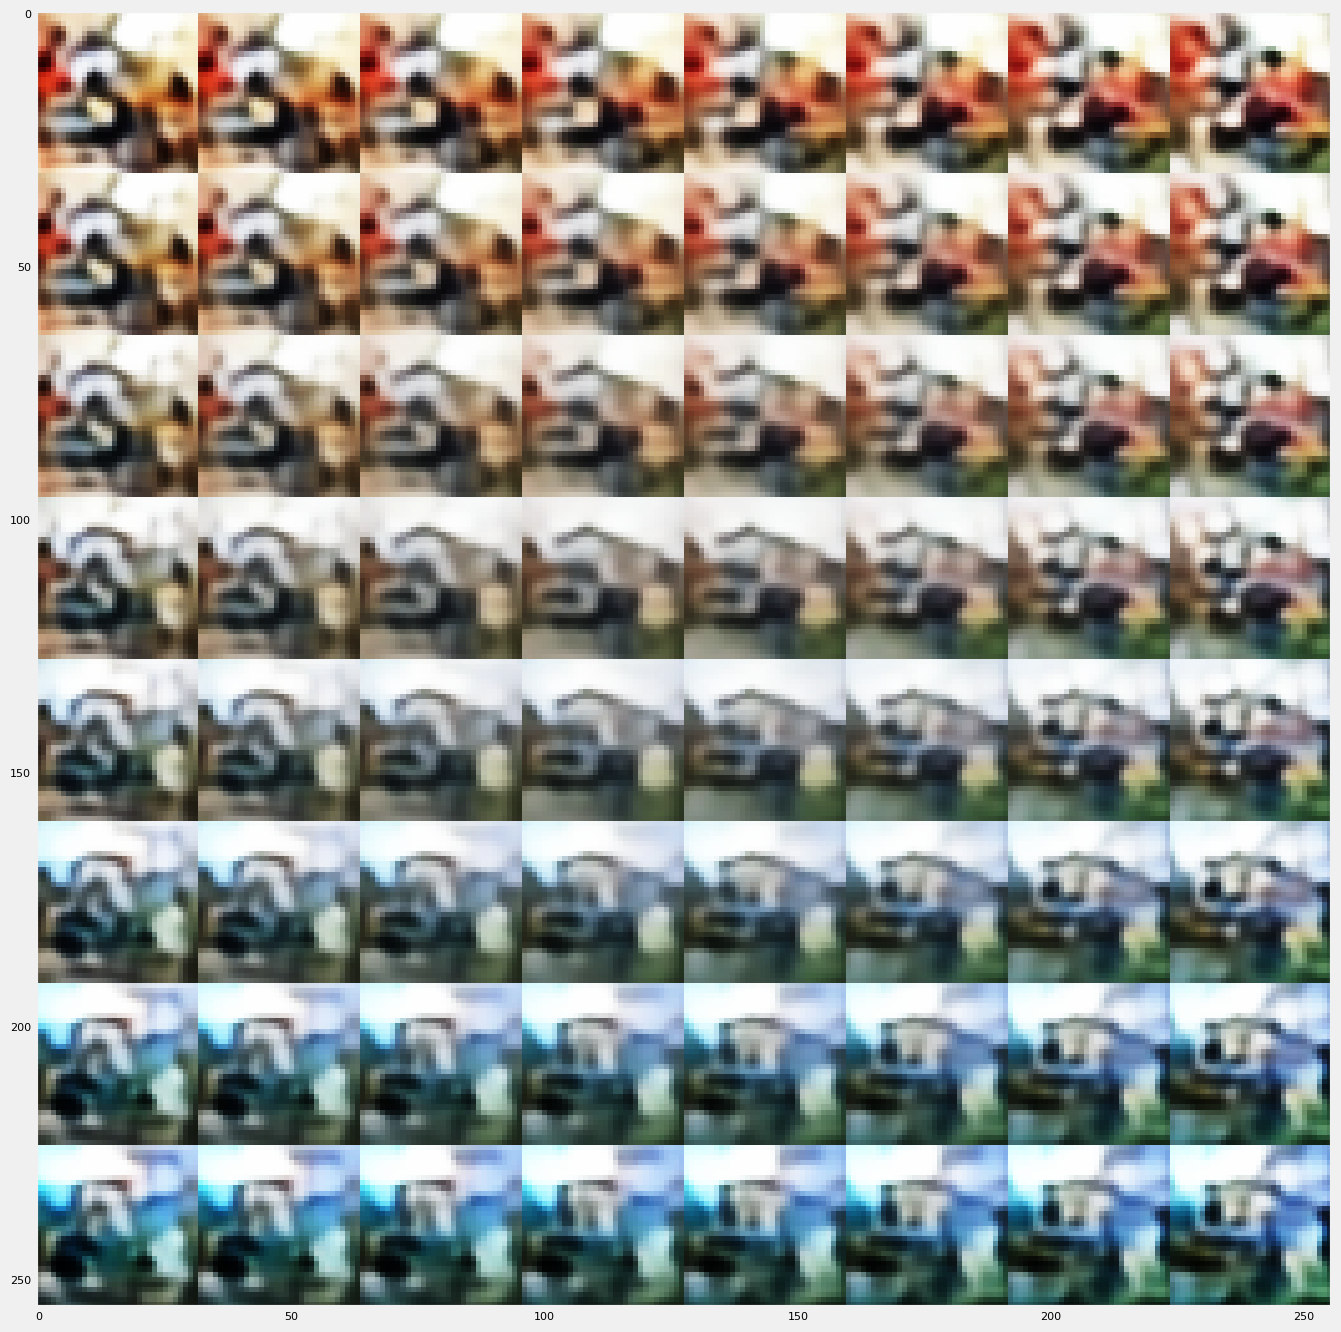

In [15]:
def display_manifold(base_vec, n=5, axis_x=0, axis_y=1):
    width, height = 32, 32
    bound_x, bound_y = 15, 15

    figure = np.zeros((height * (n if bound_y > 0 else 1), width * (n if bound_x > 0 else 1), 3))
    grid_x = np.linspace(-bound_x, bound_x, n) if bound_x > 0 else [0]
    grid_y = np.linspace(-bound_y, bound_y, n) if bound_y > 0 else [0]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = base_vec.copy()
            z_sample[axis_x] = xi 
            z_sample[axis_y] = yi 

            x_decoded = decoder.predict(np.expand_dims(z_sample, axis=0),
                                        verbose=0)
            sample = np.clip(x_decoded[0], 0, 1)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = sample

    plt.figure(figsize=(16, 16))
    plt.imshow(figure)
    plt.grid(False)
    plt.show()

idx = 16
_, _, base_vec = encoder.predict(np.array([cifar[idx],]),
                                 verbose=0)
display_manifold(base_vec[0], 8)